# Single Layer Perceptron (SLP) for MNIST Classification

This notebook implements a simple Single Layer Perceptron to classify handwritten digits from the MNIST dataset.

## Import Libraries

In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Load MNIST Dataset

In [6]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n", train_dataset)

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the training dataset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Visualize Sample Images

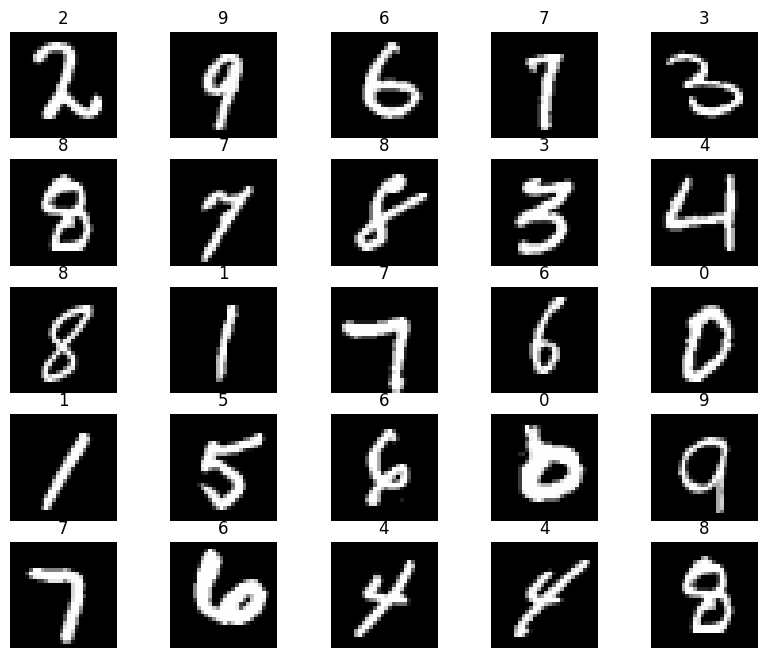

In [7]:
h = plt.figure(figsize=(10,8))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    random_idx = torch.randint(len(train_dataset), size=(1,)).item() 
    img, label = train_dataset[random_idx]
    h.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## Define the SLP Model

In [8]:
class SLP(nn.Module):
    # Constructor
    def __init__(self, input_size, output_size):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    # Prediction
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

## Initialize Model and Set Device

In [9]:
input_dim = 28*28
output_dim = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    device = "mps" if torch.backends.mps.is_available() else "cpu"

print ("Using device:", device)
    
model = SLP(input_dim, output_dim).to(device)
print('The model: \n', model)

Using device: cuda
The model: 
 SLP(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## Inspect Model Parameters

In [10]:
print('W: ', list(model.parameters())[0].size())
print('b: ', list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


In [11]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0123, -0.0334,  0.0260,  ..., -0.0203,  0.0066,  0.0248],
                      [ 0.0032, -0.0191, -0.0272,  ..., -0.0117, -0.0206, -0.0283],
                      [-0.0194,  0.0105, -0.0033,  ...,  0.0230,  0.0034,  0.0174],
                      ...,
                      [ 0.0241,  0.0136,  0.0216,  ..., -0.0197,  0.0225, -0.0035],
                      [-0.0229,  0.0126, -0.0347,  ...,  0.0266,  0.0047,  0.0112],
                      [-0.0306, -0.0307, -0.0144,  ...,  0.0248,  0.0085,  0.0225]],
                     device='cuda:0')),
             ('linear.bias',
              tensor([ 0.0042,  0.0147, -0.0324, -0.0231, -0.0243, -0.0161,  0.0229,  0.0042,
                       0.0084,  0.0290], device='cuda:0'))])

In [12]:
print('W: ', model.state_dict()['linear.weight'].size())
print('b: ', model.state_dict()['linear.bias'].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


## Visualize Model Weights

In [18]:
def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data.cpu()
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel(f"class: {i}")

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

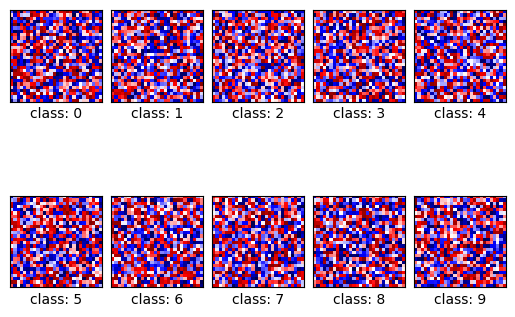

In [19]:
PlotParameters(model=model)

## Setup Training Components

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

## Define Training Function

In [1]:
# Initialize lists to track metrics
train_accuracy_list = []
loss_list = []

def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0
    for batchNr, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Set previously used gradient values to zero
        optimizer.zero_grad()

        # Flatten input matrix and compute prediction error
        pred = model(X.view(-1, input_dim))
        loss = loss_func(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # The following lines are calculating the accuracy values
        _, yhat = torch.max(pred.data, 1)
        correct += (yhat == y).sum().item()
        train_loss += loss
        if (batchNr+1) % 100 == 0:
            loss_val, current = loss.item(), (batchNr+1)*len(y)
            print(f"loss: {loss_val:>7f} [{current:>5d}/{size:>5d}]")
    
    accuracy = correct / size
    train_accuracy_list.append(accuracy)
    loss_list.append(train_loss.item()/size)

10000
60000

Epoch 1
---------------------------------------------
loss: 0.661064 [10000/60000]
loss: 0.629819 [20000/60000]
loss: 0.674282 [30000/60000]
loss: 0.518831 [40000/60000]
loss: 0.489170 [50000/60000]
loss: 0.407333 [60000/60000]
Validation Error: 
 Accuracy: 90.3 Avg loss: 0.364544

Epoch 2
---------------------------------------------
loss: 0.233257 [10000/60000]
loss: 0.360710 [20000/60000]
loss: 0.498797 [30000/60000]
loss: 0.398818 [40000/60000]
loss: 0.388951 [50000/60000]
loss: 0.332466 [60000/60000]
Validation Error: 
 Accuracy: 91.3 Avg loss: 0.310832

Epoch 3
---------------------------------------------
loss: 0.196931 [10000/60000]
loss: 0.299383 [20000/60000]
loss: 0.449746 [30000/60000]
loss: 0.357343 [40000/60000]
loss: 0.347056 [50000/60000]
loss: 0.305991 [60000/60000]
Validation Error: 
 Accuracy: 91.9 Avg loss: 0.291580

Epoch 4
---------------------------------------------
loss: 0.185805 [10000/60000]
loss: 0.271633 [20000/60000]
loss: 0.423796 [30000/6000

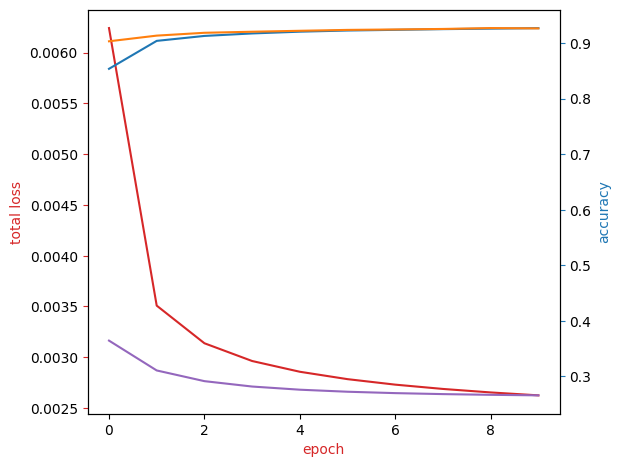

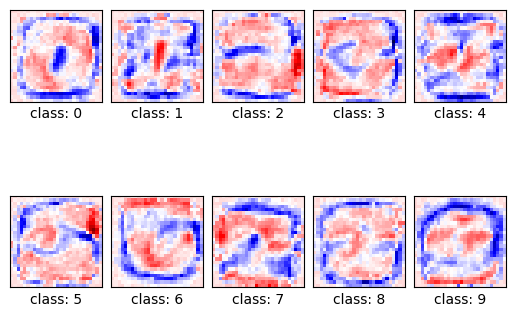

In [ ]:
val_loss_list = []
val_accuracy_list = []

# perform a prediction on the validationdata 
def validate(dataloader, model, loss_func):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    #print(num_batches)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x_test, y_test in dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            pred = model(x_test.view(-1, input_dim))
            val_loss += loss_func(pred, y_test)
            # The following lines are calculating the accuracy values
            _, yhat = torch.max(pred.data, 1)
            correct += (yhat == y_test).sum().item()
    val_loss /= num_batches  
    accuracy = correct / size
    val_accuracy_list.append(accuracy)
    val_loss_list.append(val_loss.item())
    print(f"Validation Error: \n Accuracy: {(100*accuracy):>0.1f} Avg loss: {(val_loss.item()):>8f}")
    
n_epochs = 10
loss_list = []
train_accuracy_list = []
N_test = len(validation_dataset)
print(N_test)
print(len(train_loader.dataset))

for t in range(n_epochs):
    print(f"\nEpoch {t+1}\n---------------------------------------------")
    train(train_loader, model, loss_func, optimizer)
    validate(validation_loader, model, loss_func)
print("Done")

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( train_accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

color = 'tab:orange'
ax2.plot(val_accuracy_list, color=color)

color = 'tab:purple'
ax2.plot(val_loss_list, color=color)

PlotParameters(model)